In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.measure
import scipy.ndimage

from src.datasets import BiosensorDataset, calculate_mean_and_std
from src.srunet.sru_model import UNet2, UNet4, UNet8, UNet16
from src.srunet.train import train_model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

torch.manual_seed(42)
np.random.seed(42)

data_path = 'data_with_centers/'
checkpoint_dir = 'checkpoints_srunet'
train_percent = 0.737
bio_len = 8
batch_size = 4
upscale_factor = 8
mask_size = 80 * upscale_factor

files = os.listdir(data_path)
train_size = int(train_percent * len(files))
print(train_size)
val_size = len(files) - train_size
train_files, val_files = torch.utils.data.random_split(files, [train_size, val_size])

mean, std = calculate_mean_and_std(data_path, train_files, biosensor_length=bio_len)

train_dataset = BiosensorDataset(data_path, train_files, mean, std, bool, biosensor_length=bio_len, mask_size=mask_size, augment=True)
val_dataset = BiosensorDataset(data_path, val_files, mean, std, bool, biosensor_length=bio_len, mask_size=mask_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

if upscale_factor == 2:
    model = UNet2(n_channels=bio_len, n_classes=1)
elif upscale_factor == 4:
    model = UNet4(n_channels=bio_len, n_classes=1)
elif upscale_factor == 8:
    model = UNet8(n_channels=bio_len, n_classes=1)
elif upscale_factor == 16:
    model = UNet16(n_channels=bio_len, n_classes=1)

model = model.to(device)

Using device cuda
120


In [3]:
try:
    train_model(
        model,
        device,
        train_loader,
        val_loader,
        learning_rate=0.01,
        epochs=5,
        checkpoint_dir=checkpoint_dir,
        amp=True,
    )
except torch.cuda.OutOfMemoryError:
    torch.cuda.empty_cache()
    print('Detected OutOfMemoryError!')

Starting training:
        Epochs:          5
        Batch size:      4
        Learning rate:   0.01
        Training size:   120
        Validation size: 43
        Device:          cuda
        Mixed Precision: True
    


Epoch 1/5: 100%|██████████| 120/120 [00:24<00:00,  5.00img/s, loss (batch)=0.933]


Validation Dice score: 2.3950152971963234e-10, Detection rate: 0.0
Checkpoint 1 saved!


Epoch 2/5: 100%|██████████| 120/120 [00:22<00:00,  5.30img/s, loss (batch)=0.925]


Validation Dice score: 0.2785366177558899, Detection rate: 0.5788729549585943
Checkpoint 2 saved!


Epoch 3/5: 100%|██████████| 120/120 [00:22<00:00,  5.27img/s, loss (batch)=0.857]


Validation Dice score: 0.3196732997894287, Detection rate: 0.5954352656029085
Checkpoint 3 saved!


Epoch 4/5: 100%|██████████| 120/120 [00:22<00:00,  5.42img/s, loss (batch)=0.822]


Validation Dice score: 0.2978089153766632, Detection rate: 0.5503938598262977
Checkpoint 4 saved!


Epoch 5/5: 100%|██████████| 120/120 [00:21<00:00,  5.46img/s, loss (batch)=0.803]

Validation Dice score: 0.3211469352245331, Detection rate: 0.6148252878206423
Checkpoint 5 saved!


In [6]:
from torchsummary import summary

# Load the checkpoint
checkpoint = torch.load("checkpoints_srunet/checkpoint_epoch5.pth")

# Get the learning rate and remove it from the checkpoint
lr = checkpoint.pop('learning_rate')

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

# Move the model to the device
model = model.to(device)

# Print the model summary
# summary(model, input_size=(bio_len, mask_size, mask_size))

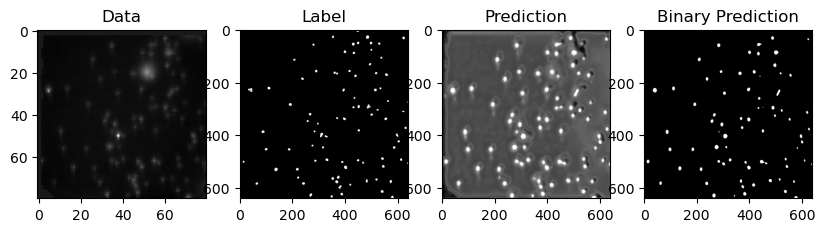

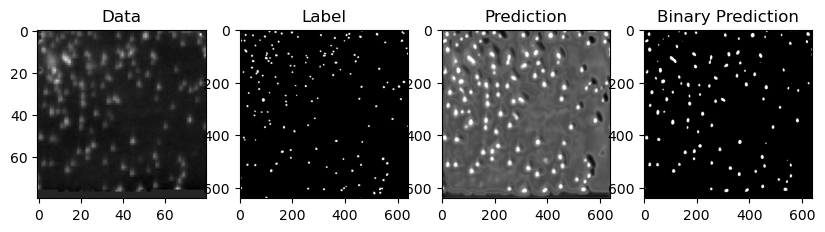

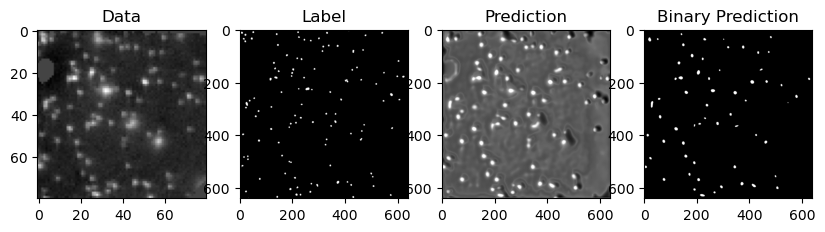

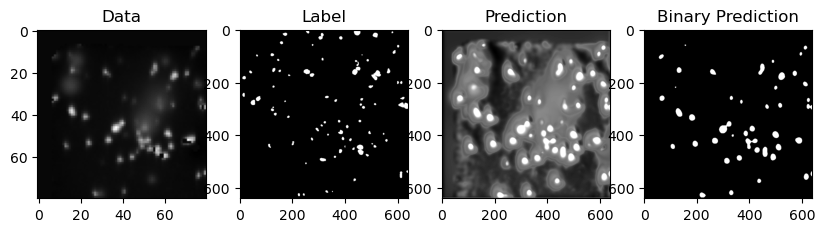

In [7]:
# Load a batch of data and labels
val_loader_iter = iter(val_loader)
data, labels = next(val_loader_iter)
data, labels = next(val_loader_iter)
data, labels = next(val_loader_iter)

# Move the data and labels to the device
data = data.to(device)
labels = labels.to(device)

# Get the predictions
predictions = model(data)

# Move the predictions and labels to the CPU and convert them to numpy arrays
predictions = predictions.cpu().detach().numpy()
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.uint8)


labels = labels.cpu().numpy()

# Plot the data, the labels, and the predictions
for i in range(len(data)):
    plt.figure(figsize=(10, 40))
    
    plt.subplot(1, 4, 1)
    plt.imshow(data[i].cpu().numpy()[-1], cmap='gray')
    plt.title('Data')
    
    plt.subplot(1, 4, 2)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.title('Label')
    
    plt.subplot(1, 4, 3)
    plt.imshow(np.squeeze(predictions[i]), cmap='gray')
    plt.title('Prediction')

    plt.subplot(1, 4, 4)
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='gray')
    plt.title('Binary Prediction')
    
    plt.show()

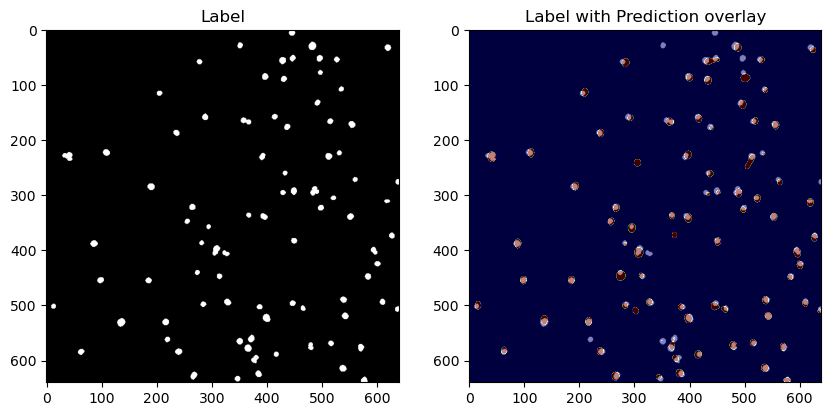

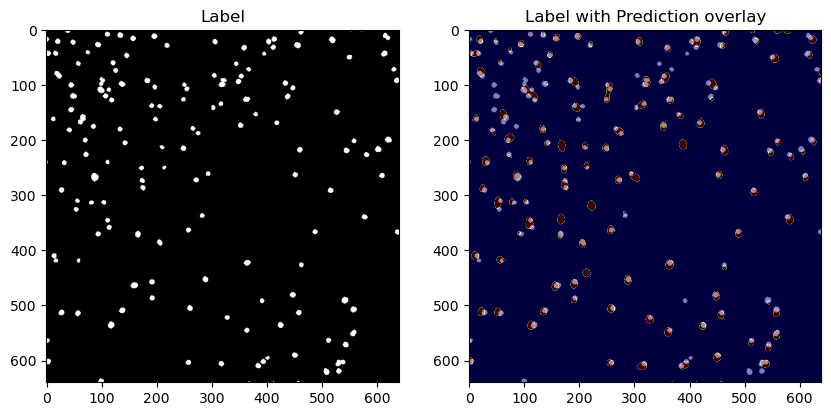

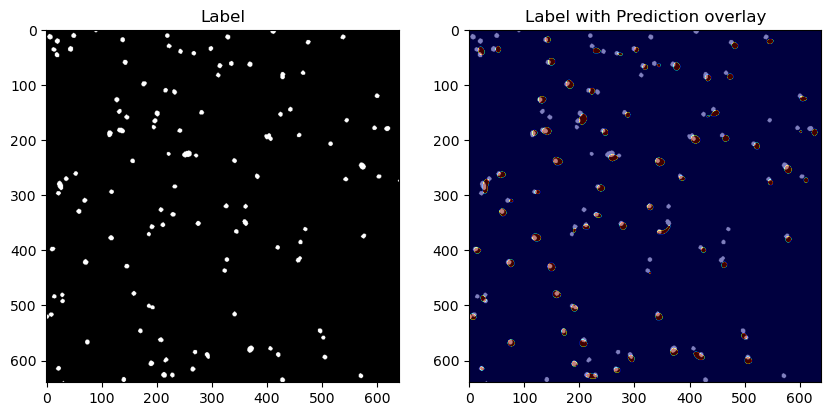

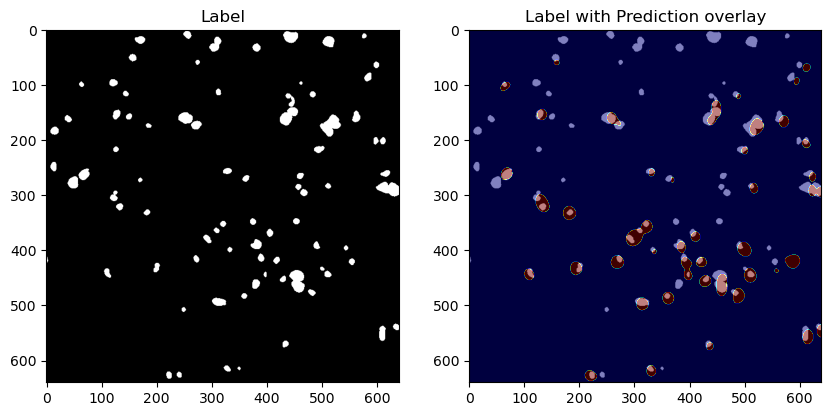

In [ ]:
# Plot the label and the prediction
for i in range(len(labels)):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.title('Label')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(labels[i]), cmap='gray')
    plt.imshow(np.squeeze(binary_predictions[i]), cmap='jet', alpha=0.5)
    plt.title('Label with Prediction overlay')
    
    plt.show()

In [ ]:
def cell_detection_skimage(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            for i in range(len(data)):
                # Label the binary prediction and count the number of cells
                _, num_cells_pred = skimage.measure.label(binary_predictions[i], return_num=True, connectivity=2)
                _, num_cells_label = skimage.measure.label(labels[i], return_num=True, connectivity=2)

                total_cells += num_cells_label
                detected_cells += num_cells_pred

    cell_detection_rate = detected_cells / total_cells if total_cells > 0 else 0

    return cell_detection_rate, total_cells, detected_cells

In [ ]:
def cell_detection_scipy(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            structure = np.ones((3, 3))

            for i in range(len(data)):
                # Label the binary prediction and count the number of cells
                _, num_cells_pred = scipy.ndimage.label(np.squeeze(binary_predictions[i]), structure=structure)
                _, num_cells_label = scipy.ndimage.label(labels[i], structure=structure)

                total_cells += num_cells_label
                detected_cells += num_cells_pred

    cell_detection_rate = detected_cells / total_cells if total_cells > 0 else 0

    return cell_detection_rate, total_cells, detected_cells

In [ ]:
def pos_pixels(model, val_loader, device, threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    total_cells = 0
    detected_cells = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, labels in val_loader:
            # Move the data and labels to the device
            data = data.to(device)
            labels = labels.to(device)

            # Get the predictions
            predictions = model(data)

            # Move the predictions and labels to the CPU and convert them to numpy arrays
            predictions = predictions.cpu().detach().numpy()
            binary_predictions = (predictions > threshold).astype(np.uint8)

            labels = labels.cpu().numpy()

            total_cells += np.sum(labels)
            detected_cells += np.sum(binary_predictions)

    return total_cells, detected_cells

In [ ]:
label, detected = pos_pixels(model, val_loader, device, threshold=0.5)
print(label, detected)

503680 532890


In [ ]:
cell_detection_rate, total, detected = cell_detection_skimage(model, val_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.6134178768664349, total cells: 4889, detected cells: 2999


In [ ]:
cell_detection_rate, total, detected = cell_detection_scipy(model, val_loader, device)
print(f'Cell detection rate: {cell_detection_rate}, total cells: {total}, detected cells: {detected}')

Cell detection rate: 0.6134178768664349, total cells: 4889, detected cells: 2999
